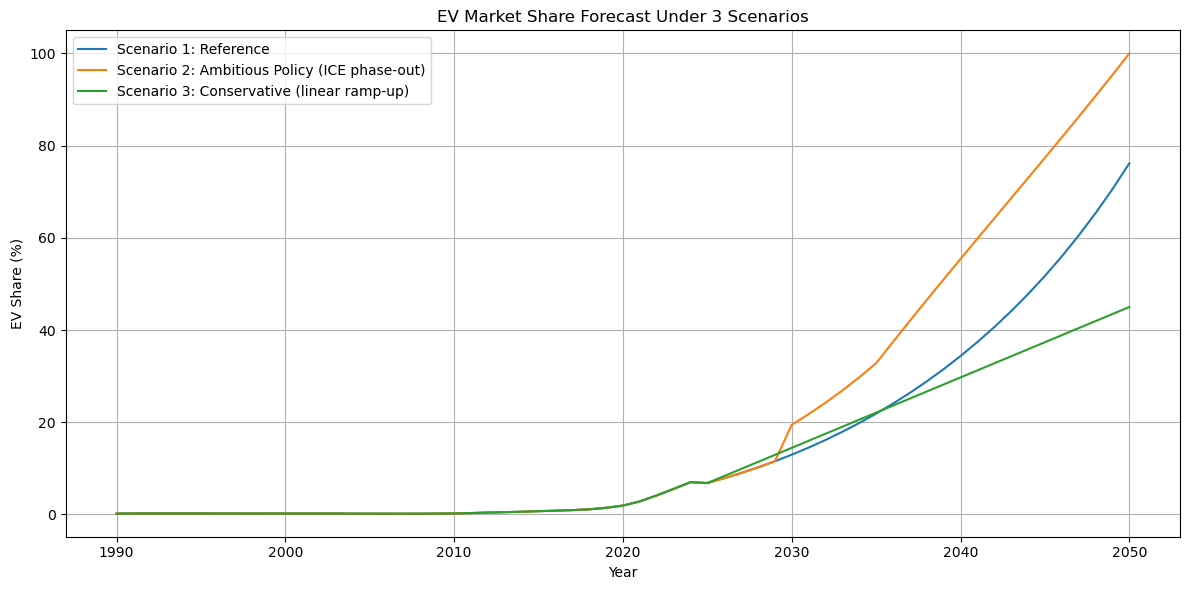

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("../prediction-results/forecasted_vehicles.csv")
df["ev_share_pct"] = df["ev_count"] / df["total_count"]

EV_GROWTH_FACTOR_SCENARIO_2 = 1.5
ICE_STOP_YEAR_SCENARIO_2 = 2030
EV_SHARE_TARGET_SCENARIO_3 = 0.45


# --- Scenario 1: Reference (no change) ---
scenario_1 = df.copy()


# --- Scenario 2: Ambitious Policy (accelerated EV growth and ICE phase-out) ---
scenario_2 = df.copy()

# Apply accelerated EV growth from 2030 onward
scenario_2.loc[scenario_2["year"] >= ICE_STOP_YEAR_SCENARIO_2, "ev_count"] *= EV_GROWTH_FACTOR_SCENARIO_2

# Gradual ICE phase-out from 2035 to 2050
ice_count_2035 = scenario_2.loc[scenario_2["year"] == 2035, "total_count"].values[0] - \
                 scenario_2.loc[scenario_2["year"] == 2035, "ev_count"].values[0]

for year in range(2036, 2051):
    retirement_fraction = (year - 2035) / (2050 - 2035)
    total_count = scenario_2.loc[scenario_2["year"] == year, "total_count"].values[0]
    remaining_ice = max(ice_count_2035 * (1 - retirement_fraction), 0)
    scenario_2.loc[scenario_2["year"] == year, "ev_count"] = total_count - remaining_ice

scenario_2["ev_share_pct"] = scenario_2["ev_count"] / scenario_2["total_count"]
scenario_2["ev_share_pct"] = scenario_2["ev_share_pct"].clip(upper=1.0)

# --- Scenario 3: Conservative (linear ramp-up to 45% by 2050) ---
scenario_3 = df.copy()
start_year = 2025
end_year = 2050
ev_share_start = scenario_3.loc[scenario_3["year"] == start_year, "ev_share_pct"].values[0]
years_range = end_year - start_year
slope = (EV_SHARE_TARGET_SCENARIO_3 - ev_share_start) / years_range

for year in range(start_year, end_year + 1):
    ev_share = ev_share_start + slope * (year - start_year)
    scenario_3.loc[scenario_3["year"] == year, "ev_share_pct"] = ev_share

scenario_3["ev_count"] = scenario_3["ev_share_pct"] * scenario_3["total_count"]
scenario_3["ev_share_pct"] = scenario_3["ev_share_pct"].clip(0, 1.0)

# --- Plot all 3 scenarios ---
plt.figure(figsize=(12, 6))
plt.plot(scenario_1["year"], scenario_1["ev_share_pct"] * 100, label="Scenario 1: Reference")
plt.plot(scenario_2["year"], scenario_2["ev_share_pct"] * 100, label="Scenario 2: Ambitious Policy (ICE phase-out)")
plt.plot(scenario_3["year"], scenario_3["ev_share_pct"] * 100, label="Scenario 3: Conservative (linear ramp-up)")

plt.title("EV Market Share Forecast Under 3 Scenarios")
plt.xlabel("Year")
plt.ylabel("EV Share (%)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [12]:
import os
export_dir = "output"
os.makedirs(export_dir, exist_ok=True)

# Export each scenario to CSV
scenario_1.to_csv(os.path.join(export_dir, "scenario_1_reference.csv"), index=False)
scenario_2.to_csv(os.path.join(export_dir, "scenario_2_ambitious_policy.csv"), index=False)
scenario_3.to_csv(os.path.join(export_dir, "scenario_3_conservative.csv"), index=False)
